In [1]:
from deepee import (PrivacyWrapper, PrivacyWatchdog, UniformDataLoader,
                     ModelSurgeon, SurgicalProcedures)
import numpy as np
import torch
from torch import nn
from torchvision import datasets, transforms
from torchvision.transforms import functional as F
from matplotlib import pyplot as plt
import cv2
from skimage.restoration import denoise_tv_chambolle

class args:
    batch_size = 200
    test_batch_size = 200
    log_interval = 1000
    num_epochs = 5
    device = "cuda" if torch.cuda.is_available() else "cpu"
device = args.device

In [2]:
train_loader = UniformDataLoader(
    
    datasets.MNIST(
        "./data",
        train=True,
        download=True,
        transform=transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
            ]
        ),
    ),
    batch_size=args.batch_size,
)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "./data",
        train=False,
        transform=transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
            ]
        ),
    ),
    batch_size=args.test_batch_size,
    shuffle=True,
) 

/Users/helena/.virtualenvs/thesis/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.bn1 = nn.BatchNorm1d(256, track_running_stats=False)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = torch.sigmoid(self.fc1(x))
        x = self.bn1(x)
        x = torch.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return x

In [4]:
def tv_denoiser(model, weight):
    model.wrapped_model.fc1.weight.grad = torch.tensor(
        denoise_tv_chambolle(np.array(model.wrapped_model.fc1.weight.grad), weight)
    )
    model.wrapped_model.fc2.weight.grad = torch.tensor(
        denoise_tv_chambolle(np.array(model.wrapped_model.fc2.weight.grad), weight)
    )
    model.wrapped_model.fc3.weight.grad = torch.tensor(
        denoise_tv_chambolle(np.array(model.wrapped_model.fc3.weight.grad), weight)
    )
        
def plot_grad_hist(model, layer, rows, columns, i, title="Gradient histogram", y_lim=7500):
    bins = 50
    x_range = (-0.02, 0.02)
    
    fig.add_subplot(rows, columns, i)
    if layer == 1:
        plt.hist(
            np.transpose(np.array(torch.flatten(model.fc1.weight.grad))), 
            bins=bins, 
            range=x_range
        )
    elif layer == 2:
        plt.hist(
            np.transpose(np.array(torch.flatten(model.fc2.weight.grad))), 
            bins=bins, 
            range=x_range
        )
    elif layer == 3:
        plt.hist(
            np.transpose(np.array(torch.flatten(model.fc3.weight.grad))), 
            bins=bins, 
            range=x_range
        )
    plt.title(title)
    plt.ylim(0, y_lim)
    
def plot_grad_image(model, layer, rows, columns, i, title="Gradient image"):
    fig.add_subplot(rows, columns, i)
    if layer == 1:
        plt.imshow(F.to_pil_image(model.fc1.weight.grad))
    elif layer == 2:
        plt.imshow(F.to_pil_image(model.fc2.weight.grad))
    elif layer == 3:
        plt.imshow(F.to_pil_image(model.fc3.weight.grad))
    plt.title(title)
    plt.axis("off")

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.344086


INFO:root:Privacy spent at 100 steps: 0.18
INFO:root:Privacy spent at 200 steps: 0.27
INFO:root:Privacy spent at 300 steps: 0.34



Test set: Average loss: 2.3068, Accuracy: 1321/10000 (13%)
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.311889


INFO:root:Privacy spent at 400 steps: 0.39
INFO:root:Privacy spent at 500 steps: 0.44
INFO:root:Privacy spent at 600 steps: 0.49



Test set: Average loss: 2.2800, Accuracy: 2075/10000 (21%)
Train Epoch: 2 [0/60000 (0%)]	Loss: 2.275942


INFO:root:Privacy spent at 700 steps: 0.53
INFO:root:Privacy spent at 800 steps: 0.57
INFO:root:Privacy spent at 900 steps: 0.61



Test set: Average loss: 2.2725, Accuracy: 1010/10000 (10%)
Train Epoch: 3 [0/60000 (0%)]	Loss: 2.270050


INFO:root:Privacy spent at 1000 steps: 0.65
INFO:root:Privacy spent at 1100 steps: 0.68
INFO:root:Privacy spent at 1200 steps: 0.72



Test set: Average loss: 2.2478, Accuracy: 2114/10000 (21%)
Train Epoch: 4 [0/60000 (0%)]	Loss: 2.246294


INFO:root:Privacy spent at 1300 steps: 0.75
INFO:root:Privacy spent at 1400 steps: 0.78
INFO:root:Privacy spent at 1500 steps: 0.81



Test set: Average loss: 2.2342, Accuracy: 2694/10000 (27%)


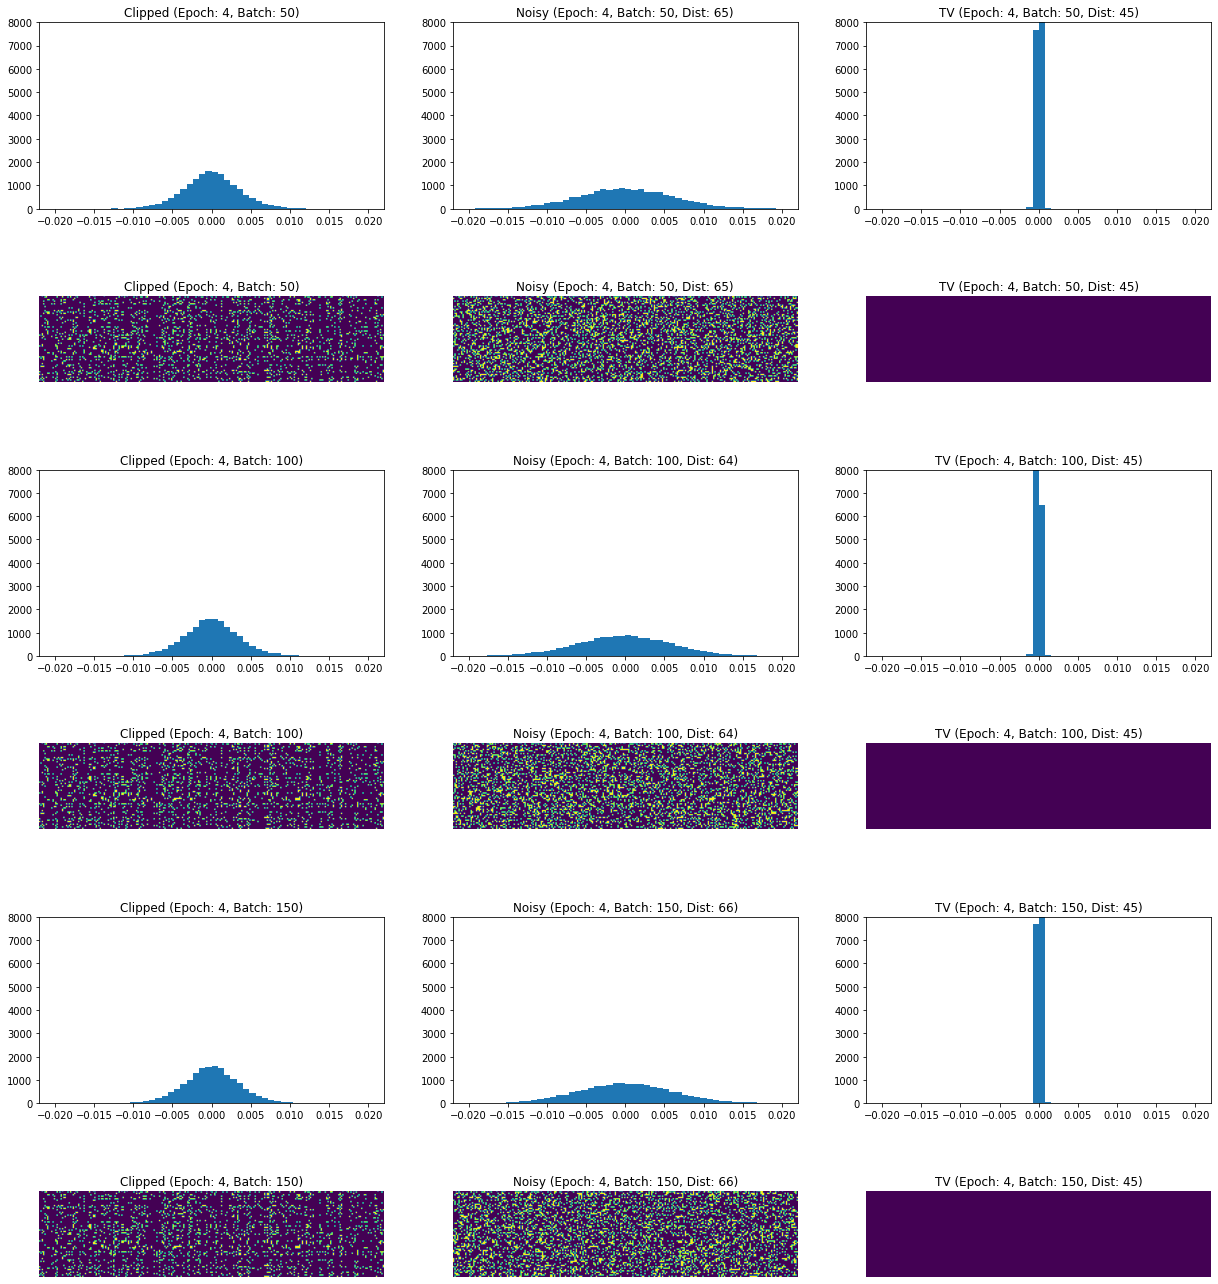

In [5]:
watchdog = PrivacyWatchdog(
    train_loader,
    target_epsilon=1.0,
    abort=False,
    target_delta=1e-5,
    fallback_to_rdp=False,
)
model = PrivacyWrapper(SimpleNet(), args.batch_size, 1.0, 1.0, watchdog=watchdog).to(
    args.device
)
optimizer = torch.optim.SGD(model.wrapped_model.parameters(), lr=0.1)

surgeon = ModelSurgeon(SurgicalProcedures.BN_to_GN)
model = surgeon.operate(model)

weight = 1
noisy_dists = np.array([])
gauss_dists = np.array([])
plot_layer = 2
y_lim = 8000
rows = 6
columns = 3
i = 1
fig = plt.figure(figsize=(columns*7, rows*4))

# Train
for epoch in range(args.num_epochs):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = torch.nn.CrossEntropyLoss()(output, target)
        loss.backward()
        
        if epoch == 4 and (batch_idx == 50 or batch_idx == 100 or batch_idx == 150):
            model.clip_and_accumulate()
            
            clipped_grad = torch.flatten(model.wrapped_model.fc2.weight.grad).detach().clone()
            
            title = "Clipped (Epoch: " + str(epoch) + ", Batch: " + str(batch_idx) + ")"
            plot_grad_hist(model.wrapped_model, plot_layer, rows, columns, i, title, y_lim)
            plot_grad_image(model.wrapped_model, plot_layer, rows, columns, i+3, title)

            model.noise_gradient()

            noisy_dist = sum(abs(clipped_grad - torch.flatten(model.wrapped_model.fc2.weight.grad)))
            noisy_dists = np.append(noisy_dists, noisy_dist)
            title = "Noisy (Epoch: " + str(epoch) + ", Batch: " + str(batch_idx) + ", Dist: " + str(int(noisy_dist)) + ")"
            plot_grad_hist(model.wrapped_model, plot_layer, rows, columns, i+1, title, y_lim)
            plot_grad_image(model.wrapped_model, plot_layer, rows, columns, i+4, title)
            
            tv_denoiser(model, weight)
            
            gauss_dist = sum(abs(clipped_grad - torch.flatten(model.wrapped_model.fc2.weight.grad)))
            gauss_dists = np.append(gauss_dists, gauss_dist)
            title = "TV (Epoch: " + str(epoch) + ", Batch: " + str(batch_idx) + ", Dist: " + str(int(gauss_dist)) + ")"
            plot_grad_hist(model.wrapped_model, plot_layer, rows, columns, i+2, title, y_lim)
            plot_grad_image(model.wrapped_model, plot_layer, rows, columns, i+5, title)
            
            i = i+6
        else:
            model.clip_and_accumulate()
            model.noise_gradient()
            tv_denoiser(model, weight)

        optimizer.step()
        model.prepare_next_batch()
        if batch_idx % args.log_interval == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    len(train_loader.dataset),
                    100.0 * batch_idx / len(train_loader),
                    loss.item(),
                )
            )

    # Test
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += torch.nn.CrossEntropyLoss(reduction="sum")(
                output, target
            ).item()  # sum up batch loss
            pred = output.argmax(
                dim=1, keepdim=True
            )  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print(
        "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)".format(
            test_loss,
            correct,
            len(test_loader.dataset),
            100.0 * correct / len(test_loader.dataset),
        )
    )

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.350572


INFO:root:Privacy spent at 100 steps: 0.18
INFO:root:Privacy spent at 200 steps: 0.27
INFO:root:Privacy spent at 300 steps: 0.34



Test set: Average loss: 2.2847, Accuracy: 1019/10000 (10%)
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.296935


INFO:root:Privacy spent at 400 steps: 0.39
INFO:root:Privacy spent at 500 steps: 0.44
INFO:root:Privacy spent at 600 steps: 0.49



Test set: Average loss: 2.2234, Accuracy: 3102/10000 (31%)
Train Epoch: 2 [0/60000 (0%)]	Loss: 2.224749


INFO:root:Privacy spent at 700 steps: 0.53
INFO:root:Privacy spent at 800 steps: 0.57
INFO:root:Privacy spent at 900 steps: 0.61



Test set: Average loss: 2.1689, Accuracy: 2324/10000 (23%)
Train Epoch: 3 [0/60000 (0%)]	Loss: 2.165756


INFO:root:Privacy spent at 1000 steps: 0.65
INFO:root:Privacy spent at 1100 steps: 0.68
INFO:root:Privacy spent at 1200 steps: 0.72



Test set: Average loss: 2.0792, Accuracy: 4330/10000 (43%)
Train Epoch: 4 [0/60000 (0%)]	Loss: 2.102659


INFO:root:Privacy spent at 1300 steps: 0.75
INFO:root:Privacy spent at 1400 steps: 0.78
INFO:root:Privacy spent at 1500 steps: 0.81



Test set: Average loss: 1.9681, Accuracy: 4199/10000 (42%)


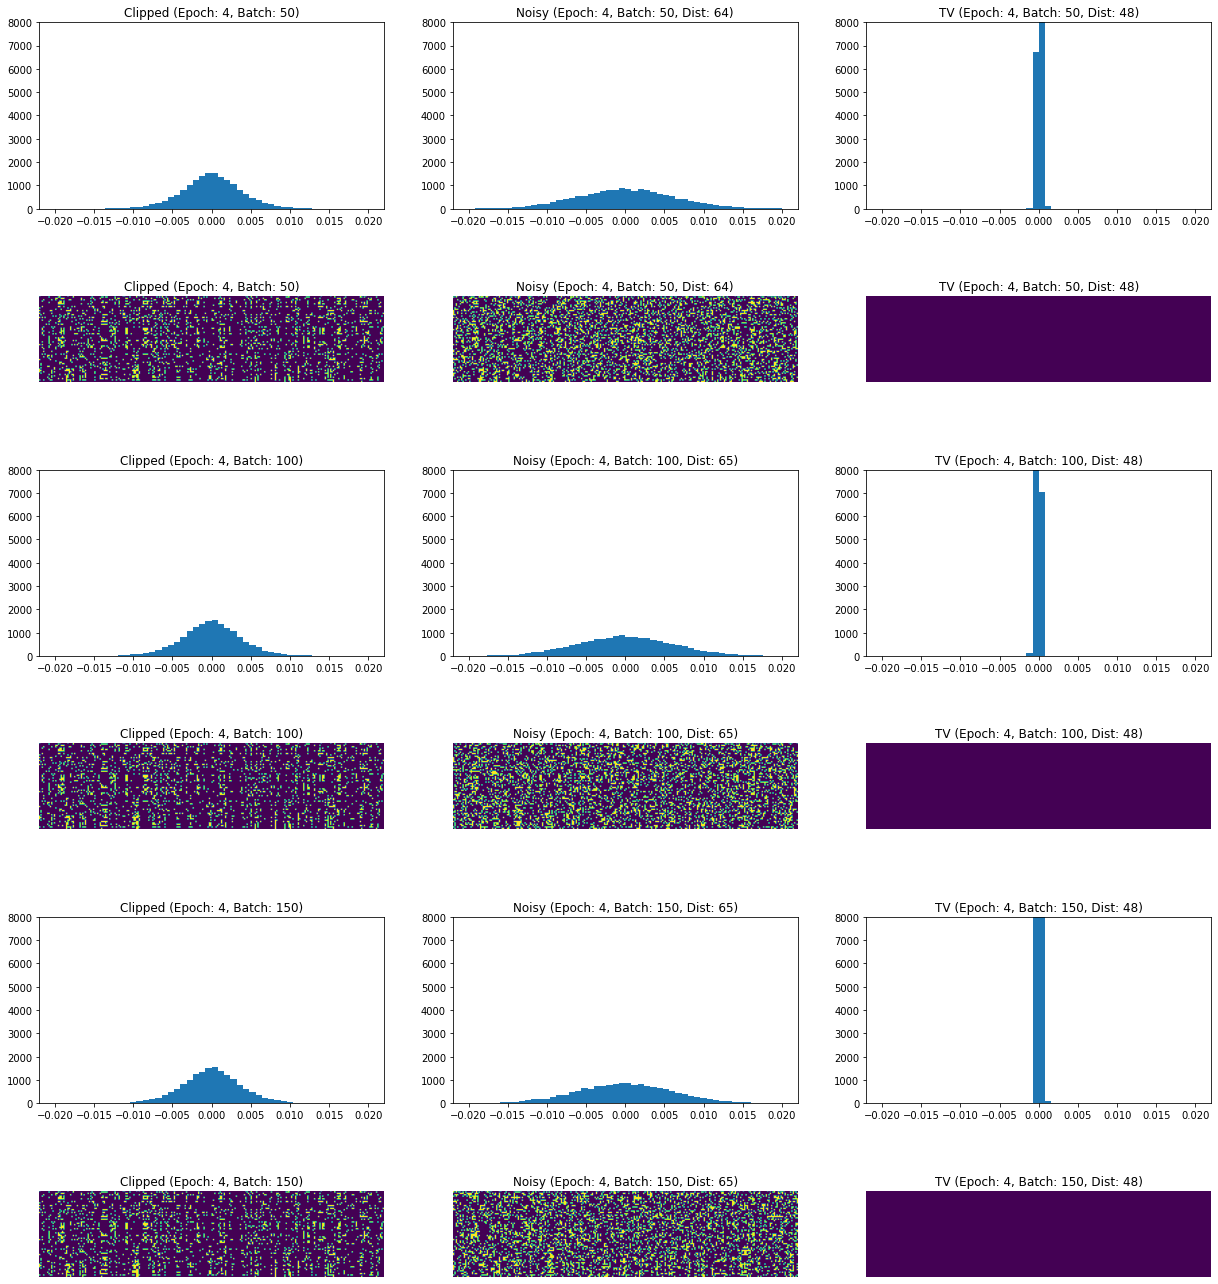

In [6]:
watchdog = PrivacyWatchdog(
    train_loader,
    target_epsilon=1.0,
    abort=False,
    target_delta=1e-5,
    fallback_to_rdp=False,
)
model = PrivacyWrapper(SimpleNet(), args.batch_size, 1.0, 1.0, watchdog=watchdog).to(
    args.device
)
optimizer = torch.optim.SGD(model.wrapped_model.parameters(), lr=0.1)

surgeon = ModelSurgeon(SurgicalProcedures.BN_to_GN)
model = surgeon.operate(model)

weight = 0.1
noisy_dists = np.array([])
gauss_dists = np.array([])
plot_layer = 2
y_lim = 8000
rows = 6
columns = 3
i = 1
fig = plt.figure(figsize=(columns*7, rows*4))

# Train
for epoch in range(args.num_epochs):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = torch.nn.CrossEntropyLoss()(output, target)
        loss.backward()
        
        if epoch == 4 and (batch_idx == 50 or batch_idx == 100 or batch_idx == 150):
            model.clip_and_accumulate()
            
            clipped_grad = torch.flatten(model.wrapped_model.fc2.weight.grad).detach().clone()
            
            title = "Clipped (Epoch: " + str(epoch) + ", Batch: " + str(batch_idx) + ")"
            plot_grad_hist(model.wrapped_model, plot_layer, rows, columns, i, title, y_lim)
            plot_grad_image(model.wrapped_model, plot_layer, rows, columns, i+3, title)

            model.noise_gradient()

            noisy_dist = sum(abs(clipped_grad - torch.flatten(model.wrapped_model.fc2.weight.grad)))
            noisy_dists = np.append(noisy_dists, noisy_dist)
            title = "Noisy (Epoch: " + str(epoch) + ", Batch: " + str(batch_idx) + ", Dist: " + str(int(noisy_dist)) + ")"
            plot_grad_hist(model.wrapped_model, plot_layer, rows, columns, i+1, title, y_lim)
            plot_grad_image(model.wrapped_model, plot_layer, rows, columns, i+4, title)
            
            tv_denoiser(model, weight)
            
            gauss_dist = sum(abs(clipped_grad - torch.flatten(model.wrapped_model.fc2.weight.grad)))
            gauss_dists = np.append(gauss_dists, gauss_dist)
            title="TV (Epoch: " + str(epoch) + ", Batch: " + str(batch_idx) + ", Dist: " + str(int(gauss_dist)) + ")"
            plot_grad_hist(model.wrapped_model, plot_layer, rows, columns, i+2, title, y_lim)
            plot_grad_image(model.wrapped_model, plot_layer, rows, columns, i+5, title)
            
            i = i+6
        else:
            model.clip_and_accumulate()
            model.noise_gradient()
            tv_denoiser(model, weight)

        optimizer.step()
        model.prepare_next_batch()
        if batch_idx % args.log_interval == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    len(train_loader.dataset),
                    100.0 * batch_idx / len(train_loader),
                    loss.item(),
                )
            )

    # Test
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += torch.nn.CrossEntropyLoss(reduction="sum")(
                output, target
            ).item()  # sum up batch loss
            pred = output.argmax(
                dim=1, keepdim=True
            )  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print(
        "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)".format(
            test_loss,
            correct,
            len(test_loader.dataset),
            100.0 * correct / len(test_loader.dataset),
        )
    )

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.301993


INFO:root:Privacy spent at 100 steps: 0.18
INFO:root:Privacy spent at 200 steps: 0.27
INFO:root:Privacy spent at 300 steps: 0.34



Test set: Average loss: 2.1061, Accuracy: 2679/10000 (27%)
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.096087


INFO:root:Privacy spent at 400 steps: 0.39
INFO:root:Privacy spent at 500 steps: 0.44
INFO:root:Privacy spent at 600 steps: 0.49



Test set: Average loss: 1.4530, Accuracy: 6872/10000 (69%)
Train Epoch: 2 [0/60000 (0%)]	Loss: 1.474807


INFO:root:Privacy spent at 700 steps: 0.53
INFO:root:Privacy spent at 800 steps: 0.57
INFO:root:Privacy spent at 900 steps: 0.61



Test set: Average loss: 0.7759, Accuracy: 8053/10000 (81%)
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.712224


INFO:root:Privacy spent at 1000 steps: 0.65
INFO:root:Privacy spent at 1100 steps: 0.68
INFO:root:Privacy spent at 1200 steps: 0.72



Test set: Average loss: 0.5331, Accuracy: 8526/10000 (85%)
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.533285


INFO:root:Privacy spent at 1300 steps: 0.75
INFO:root:Privacy spent at 1400 steps: 0.78
INFO:root:Privacy spent at 1500 steps: 0.81



Test set: Average loss: 0.4258, Accuracy: 8854/10000 (89%)


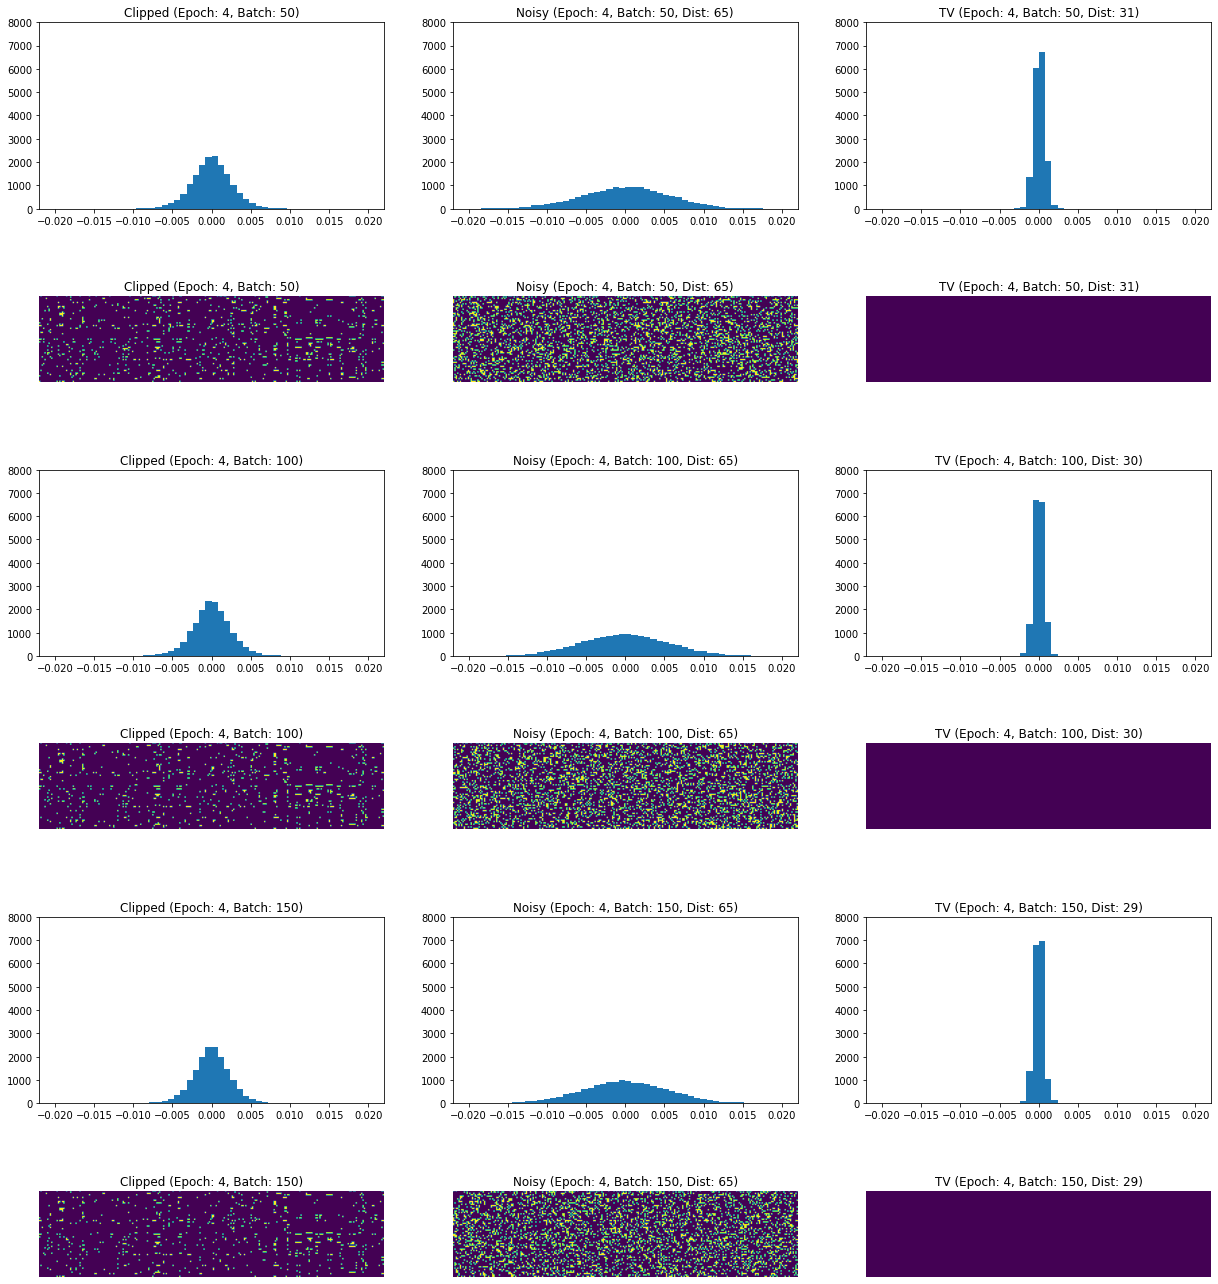

In [7]:
watchdog = PrivacyWatchdog(
    train_loader,
    target_epsilon=1.0,
    abort=False,
    target_delta=1e-5,
    fallback_to_rdp=False,
)
model = PrivacyWrapper(SimpleNet(), args.batch_size, 1.0, 1.0, watchdog=watchdog).to(
    args.device
)
optimizer = torch.optim.SGD(model.wrapped_model.parameters(), lr=0.1)

surgeon = ModelSurgeon(SurgicalProcedures.BN_to_GN)
model = surgeon.operate(model)

weight = 0.01
noisy_dists = np.array([])
gauss_dists = np.array([])
plot_layer = 2
y_lim = 8000
rows = 6
columns = 3
i = 1
fig = plt.figure(figsize=(columns*7, rows*4))

# Train
for epoch in range(args.num_epochs):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = torch.nn.CrossEntropyLoss()(output, target)
        loss.backward()
        
        if epoch == 4 and (batch_idx == 50 or batch_idx == 100 or batch_idx == 150):
            model.clip_and_accumulate()
            
            clipped_grad = torch.flatten(model.wrapped_model.fc2.weight.grad).detach().clone()
            
            title = "Clipped (Epoch: " + str(epoch) + ", Batch: " + str(batch_idx) + ")"
            plot_grad_hist(model.wrapped_model, plot_layer, rows, columns, i, title, y_lim)
            plot_grad_image(model.wrapped_model, plot_layer, rows, columns, i+3, title)

            model.noise_gradient()

            noisy_dist = sum(abs(clipped_grad - torch.flatten(model.wrapped_model.fc2.weight.grad)))
            noisy_dists = np.append(noisy_dists, noisy_dist)
            title = "Noisy (Epoch: " + str(epoch) + ", Batch: " + str(batch_idx) + ", Dist: " + str(int(noisy_dist)) + ")"
            plot_grad_hist(model.wrapped_model, plot_layer, rows, columns, i+1, title, y_lim)
            plot_grad_image(model.wrapped_model, plot_layer, rows, columns, i+4, title)
            
            tv_denoiser(model, weight)
            
            gauss_dist = sum(abs(clipped_grad - torch.flatten(model.wrapped_model.fc2.weight.grad)))
            gauss_dists = np.append(gauss_dists, gauss_dist)
            title="TV (Epoch: " + str(epoch) + ", Batch: " + str(batch_idx) + ", Dist: " + str(int(gauss_dist)) + ")"
            plot_grad_hist(model.wrapped_model, plot_layer, rows, columns, i+2, title, y_lim)
            plot_grad_image(model.wrapped_model, plot_layer, rows, columns, i+5, title)
            
            i = i+6
        else:
            model.clip_and_accumulate()
            model.noise_gradient()
            tv_denoiser(model, weight)

        optimizer.step()
        model.prepare_next_batch()
        if batch_idx % args.log_interval == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    len(train_loader.dataset),
                    100.0 * batch_idx / len(train_loader),
                    loss.item(),
                )
            )

    # Test
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += torch.nn.CrossEntropyLoss(reduction="sum")(
                output, target
            ).item()  # sum up batch loss
            pred = output.argmax(
                dim=1, keepdim=True
            )  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print(
        "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)".format(
            test_loss,
            correct,
            len(test_loader.dataset),
            100.0 * correct / len(test_loader.dataset),
        )
    )

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.404368


INFO:root:Privacy spent at 100 steps: 0.18
INFO:root:Privacy spent at 200 steps: 0.27
INFO:root:Privacy spent at 300 steps: 0.34



Test set: Average loss: 0.7562, Accuracy: 8007/10000 (80%)
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.819556


INFO:root:Privacy spent at 400 steps: 0.39
INFO:root:Privacy spent at 500 steps: 0.44
INFO:root:Privacy spent at 600 steps: 0.49



Test set: Average loss: 0.4367, Accuracy: 8893/10000 (89%)
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.408756


INFO:root:Privacy spent at 700 steps: 0.53
INFO:root:Privacy spent at 800 steps: 0.57
INFO:root:Privacy spent at 900 steps: 0.61



Test set: Average loss: 0.4064, Accuracy: 9064/10000 (91%)
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.630277


INFO:root:Privacy spent at 1000 steps: 0.65
INFO:root:Privacy spent at 1100 steps: 0.68
INFO:root:Privacy spent at 1200 steps: 0.72



Test set: Average loss: 0.3533, Accuracy: 9162/10000 (92%)
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.560865


INFO:root:Privacy spent at 1300 steps: 0.75
INFO:root:Privacy spent at 1400 steps: 0.78
INFO:root:Privacy spent at 1500 steps: 0.81



Test set: Average loss: 0.2854, Accuracy: 9265/10000 (93%)


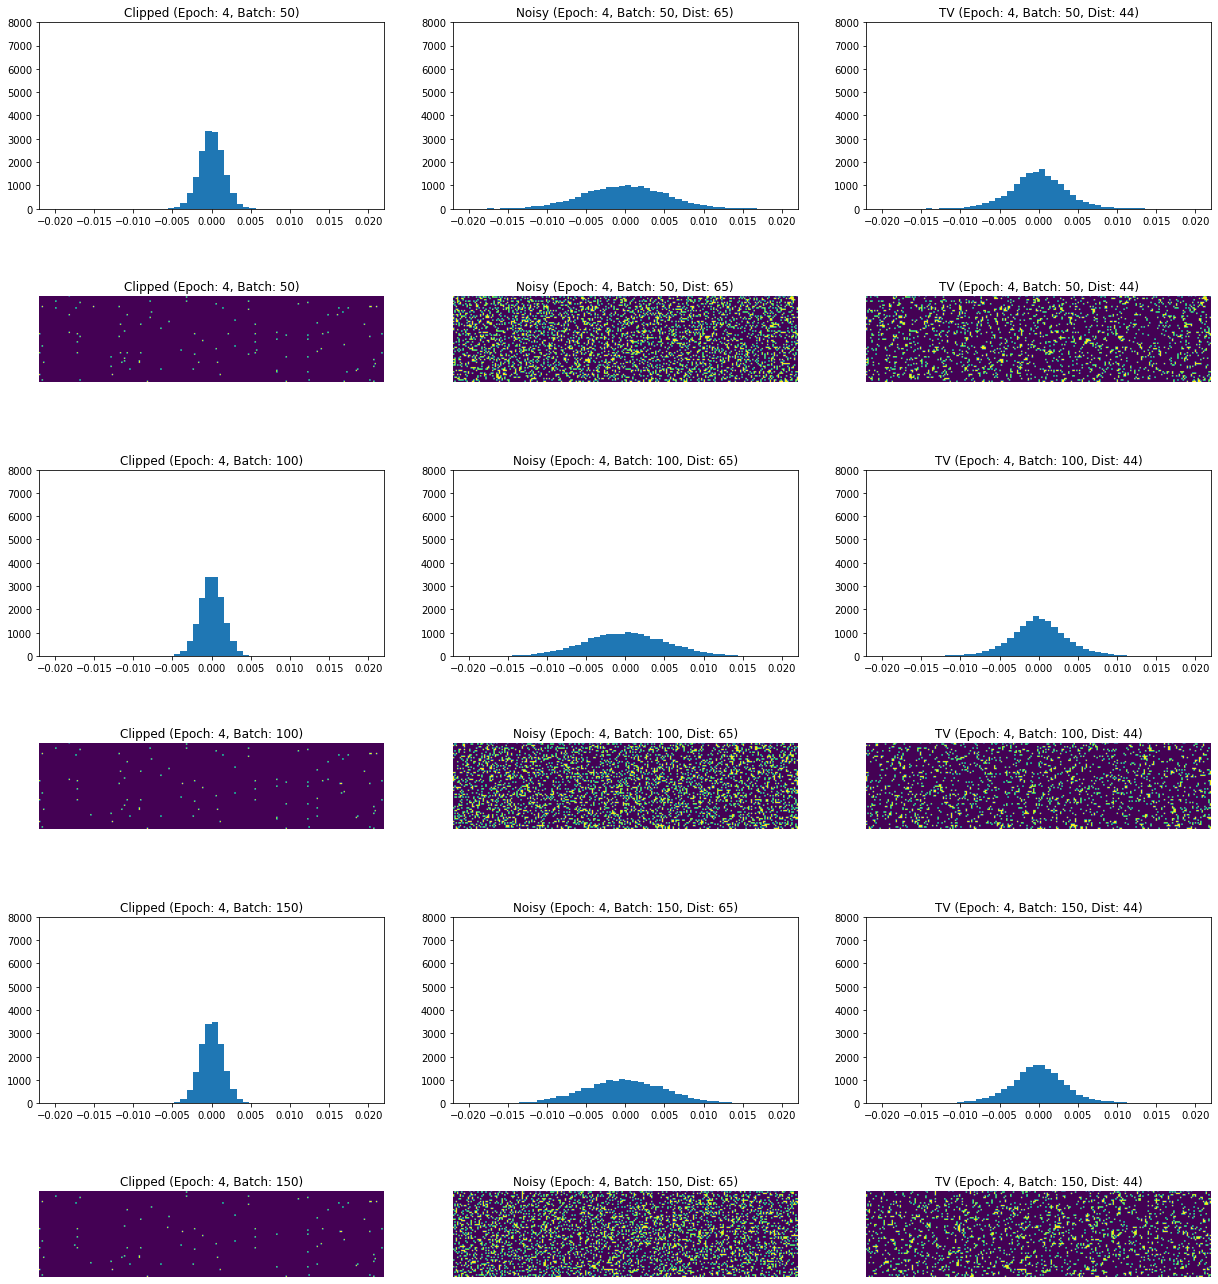

In [8]:
watchdog = PrivacyWatchdog(
    train_loader,
    target_epsilon=1.0,
    abort=False,
    target_delta=1e-5,
    fallback_to_rdp=False,
)
model = PrivacyWrapper(SimpleNet(), args.batch_size, 1.0, 1.0, watchdog=watchdog).to(
    args.device
)
optimizer = torch.optim.SGD(model.wrapped_model.parameters(), lr=0.1)

surgeon = ModelSurgeon(SurgicalProcedures.BN_to_GN)
model = surgeon.operate(model)

weight = 0.001
noisy_dists = np.array([])
gauss_dists = np.array([])
plot_layer = 2
y_lim = 8000
rows = 6
columns = 3
i = 1
fig = plt.figure(figsize=(columns*7, rows*4))

# Train
for epoch in range(args.num_epochs):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = torch.nn.CrossEntropyLoss()(output, target)
        loss.backward()
        
        if epoch == 4 and (batch_idx == 50 or batch_idx == 100 or batch_idx == 150):
            model.clip_and_accumulate()
            
            clipped_grad = torch.flatten(model.wrapped_model.fc2.weight.grad).detach().clone()
            
            title = "Clipped (Epoch: " + str(epoch) + ", Batch: " + str(batch_idx) + ")"
            plot_grad_hist(model.wrapped_model, plot_layer, rows, columns, i, title, y_lim)
            plot_grad_image(model.wrapped_model, plot_layer, rows, columns, i+3, title)

            model.noise_gradient()

            noisy_dist = sum(abs(clipped_grad - torch.flatten(model.wrapped_model.fc2.weight.grad)))
            noisy_dists = np.append(noisy_dists, noisy_dist)
            title = "Noisy (Epoch: " + str(epoch) + ", Batch: " + str(batch_idx) + ", Dist: " + str(int(noisy_dist)) + ")"
            plot_grad_hist(model.wrapped_model, plot_layer, rows, columns, i+1, title, y_lim)
            plot_grad_image(model.wrapped_model, plot_layer, rows, columns, i+4, title)
            
            tv_denoiser(model, weight)
            
            gauss_dist = sum(abs(clipped_grad - torch.flatten(model.wrapped_model.fc2.weight.grad)))
            gauss_dists = np.append(gauss_dists, gauss_dist)
            title="TV (Epoch: " + str(epoch) + ", Batch: " + str(batch_idx) + ", Dist: " + str(int(gauss_dist)) + ")"
            plot_grad_hist(model.wrapped_model, plot_layer, rows, columns, i+2, title, y_lim)
            plot_grad_image(model.wrapped_model, plot_layer, rows, columns, i+5, title)
            
            i = i+6
        else:
            model.clip_and_accumulate()
            model.noise_gradient()
            tv_denoiser(model, weight)

        optimizer.step()
        model.prepare_next_batch()
        if batch_idx % args.log_interval == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    len(train_loader.dataset),
                    100.0 * batch_idx / len(train_loader),
                    loss.item(),
                )
            )

    # Test
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += torch.nn.CrossEntropyLoss(reduction="sum")(
                output, target
            ).item()  # sum up batch loss
            pred = output.argmax(
                dim=1, keepdim=True
            )  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print(
        "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)".format(
            test_loss,
            correct,
            len(test_loader.dataset),
            100.0 * correct / len(test_loader.dataset),
        )
    )

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.334582


INFO:root:Privacy spent at 100 steps: 0.18
INFO:root:Privacy spent at 200 steps: 0.27
INFO:root:Privacy spent at 300 steps: 0.34



Test set: Average loss: 1.8008, Accuracy: 5593/10000 (56%)
Train Epoch: 1 [0/60000 (0%)]	Loss: 1.793292


INFO:root:Privacy spent at 400 steps: 0.39
INFO:root:Privacy spent at 500 steps: 0.44
INFO:root:Privacy spent at 600 steps: 0.49



Test set: Average loss: 0.7428, Accuracy: 7887/10000 (79%)
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.751087


INFO:root:Privacy spent at 700 steps: 0.53
INFO:root:Privacy spent at 800 steps: 0.57
INFO:root:Privacy spent at 900 steps: 0.61



Test set: Average loss: 0.4791, Accuracy: 8608/10000 (86%)
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.498380


INFO:root:Privacy spent at 1000 steps: 0.65
INFO:root:Privacy spent at 1100 steps: 0.68
INFO:root:Privacy spent at 1200 steps: 0.72



Test set: Average loss: 0.3887, Accuracy: 8875/10000 (89%)
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.345791


INFO:root:Privacy spent at 1300 steps: 0.75
INFO:root:Privacy spent at 1400 steps: 0.78
INFO:root:Privacy spent at 1500 steps: 0.81



Test set: Average loss: 0.3354, Accuracy: 9043/10000 (90%)


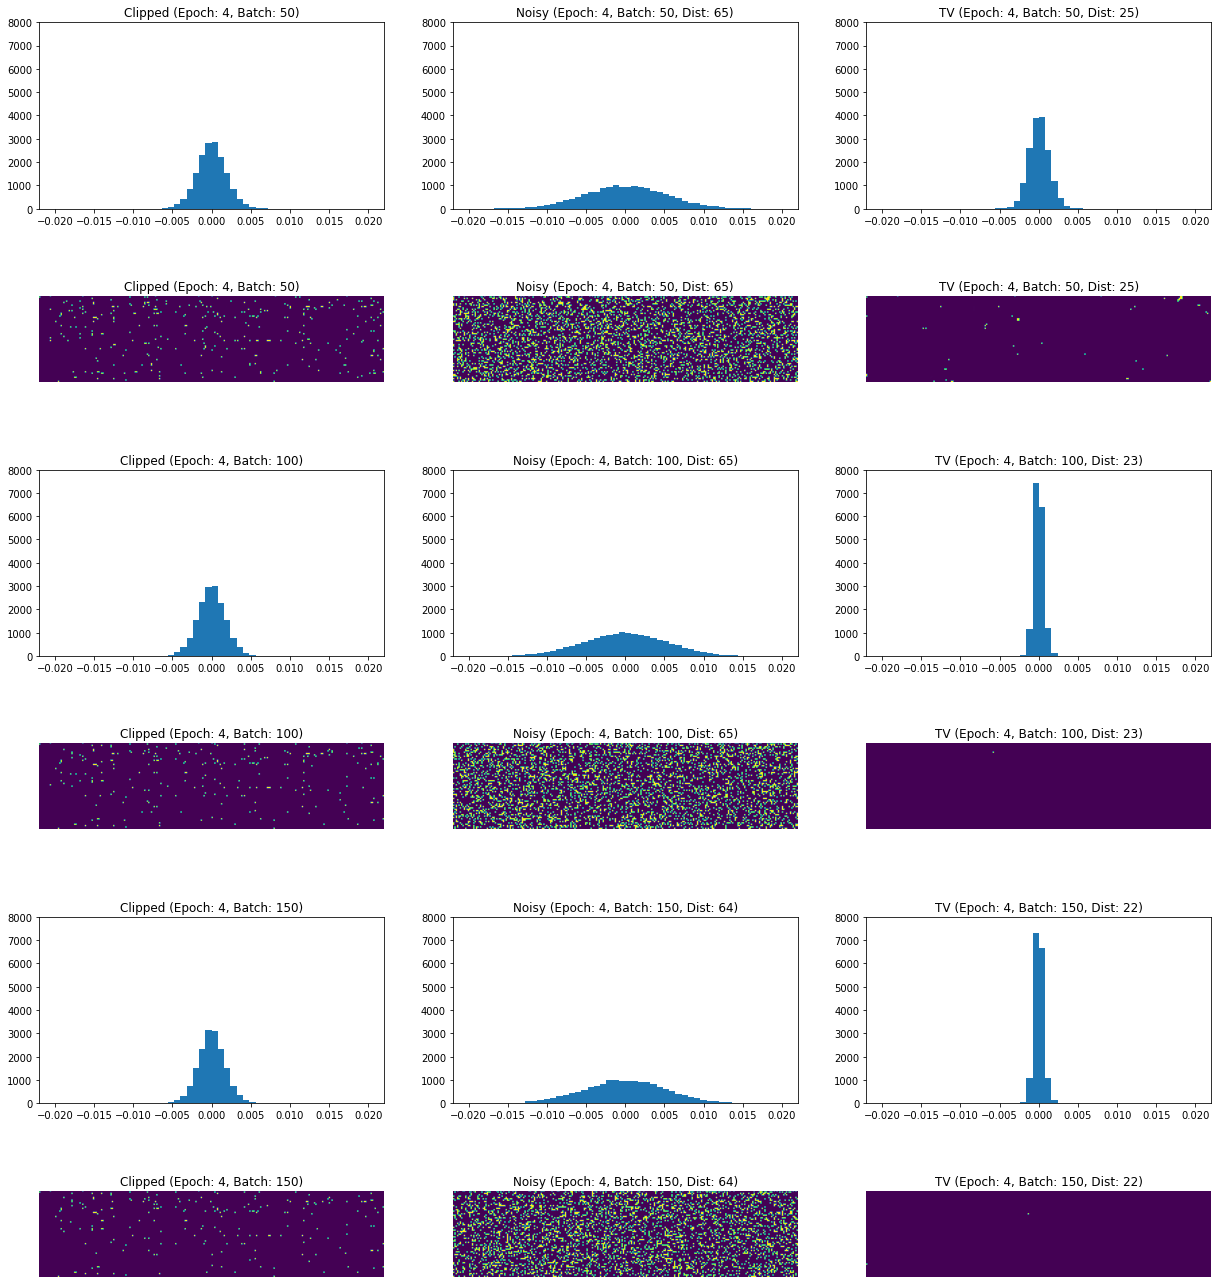

In [11]:
watchdog = PrivacyWatchdog(
    train_loader,
    target_epsilon=1.0,
    abort=False,
    target_delta=1e-5,
    fallback_to_rdp=False,
)
model = PrivacyWrapper(SimpleNet(), args.batch_size, 1.0, 1.0, watchdog=watchdog).to(
    args.device
)
optimizer = torch.optim.SGD(model.wrapped_model.parameters(), lr=0.1)

surgeon = ModelSurgeon(SurgicalProcedures.BN_to_GN)
model = surgeon.operate(model)

weight = 0.005
noisy_dists = np.array([])
gauss_dists = np.array([])
plot_layer = 2
y_lim = 8000
rows = 6
columns = 3
i = 1
fig = plt.figure(figsize=(columns*7, rows*4))

# Train
for epoch in range(args.num_epochs):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = torch.nn.CrossEntropyLoss()(output, target)
        loss.backward()
        
        if epoch == 4 and (batch_idx == 50 or batch_idx == 100 or batch_idx == 150):
            model.clip_and_accumulate()
            
            clipped_grad = torch.flatten(model.wrapped_model.fc2.weight.grad).detach().clone()
            
            title = "Clipped (Epoch: " + str(epoch) + ", Batch: " + str(batch_idx) + ")"
            plot_grad_hist(model.wrapped_model, plot_layer, rows, columns, i, title, y_lim)
            plot_grad_image(model.wrapped_model, plot_layer, rows, columns, i+3, title)

            model.noise_gradient()

            noisy_dist = sum(abs(clipped_grad - torch.flatten(model.wrapped_model.fc2.weight.grad)))
            noisy_dists = np.append(noisy_dists, noisy_dist)
            title = "Noisy (Epoch: " + str(epoch) + ", Batch: " + str(batch_idx) + ", Dist: " + str(int(noisy_dist)) + ")"
            plot_grad_hist(model.wrapped_model, plot_layer, rows, columns, i+1, title, y_lim)
            plot_grad_image(model.wrapped_model, plot_layer, rows, columns, i+4, title)
            
            tv_denoiser(model, weight)
            
            gauss_dist = sum(abs(clipped_grad - torch.flatten(model.wrapped_model.fc2.weight.grad)))
            gauss_dists = np.append(gauss_dists, gauss_dist)
            title="TV (Epoch: " + str(epoch) + ", Batch: " + str(batch_idx) + ", Dist: " + str(int(gauss_dist)) + ")"
            plot_grad_hist(model.wrapped_model, plot_layer, rows, columns, i+2, title, y_lim)
            plot_grad_image(model.wrapped_model, plot_layer, rows, columns, i+5, title)
            
            i = i+6
        else:
            model.clip_and_accumulate()
            model.noise_gradient()
            tv_denoiser(model, weight)

        optimizer.step()
        model.prepare_next_batch()
        if batch_idx % args.log_interval == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    len(train_loader.dataset),
                    100.0 * batch_idx / len(train_loader),
                    loss.item(),
                )
            )

    # Test
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += torch.nn.CrossEntropyLoss(reduction="sum")(
                output, target
            ).item()  # sum up batch loss
            pred = output.argmax(
                dim=1, keepdim=True
            )  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print(
        "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)".format(
            test_loss,
            correct,
            len(test_loader.dataset),
            100.0 * correct / len(test_loader.dataset),
        )
    )

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.328760


INFO:root:Privacy spent at 100 steps: 0.18
INFO:root:Privacy spent at 200 steps: 0.27
INFO:root:Privacy spent at 300 steps: 0.34



Test set: Average loss: 0.5849, Accuracy: 8443/10000 (84%)
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.635077


INFO:root:Privacy spent at 400 steps: 0.39
INFO:root:Privacy spent at 500 steps: 0.44
INFO:root:Privacy spent at 600 steps: 0.49



Test set: Average loss: 0.4068, Accuracy: 8952/10000 (90%)
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.344028


INFO:root:Privacy spent at 700 steps: 0.53
INFO:root:Privacy spent at 800 steps: 0.57
INFO:root:Privacy spent at 900 steps: 0.61



Test set: Average loss: 0.3698, Accuracy: 9136/10000 (91%)
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.273676


INFO:root:Privacy spent at 1000 steps: 0.65
INFO:root:Privacy spent at 1100 steps: 0.68
INFO:root:Privacy spent at 1200 steps: 0.72



Test set: Average loss: 0.3240, Accuracy: 9257/10000 (93%)
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.307927


INFO:root:Privacy spent at 1300 steps: 0.75
INFO:root:Privacy spent at 1400 steps: 0.78
INFO:root:Privacy spent at 1500 steps: 0.81



Test set: Average loss: 0.2996, Accuracy: 9309/10000 (93%)


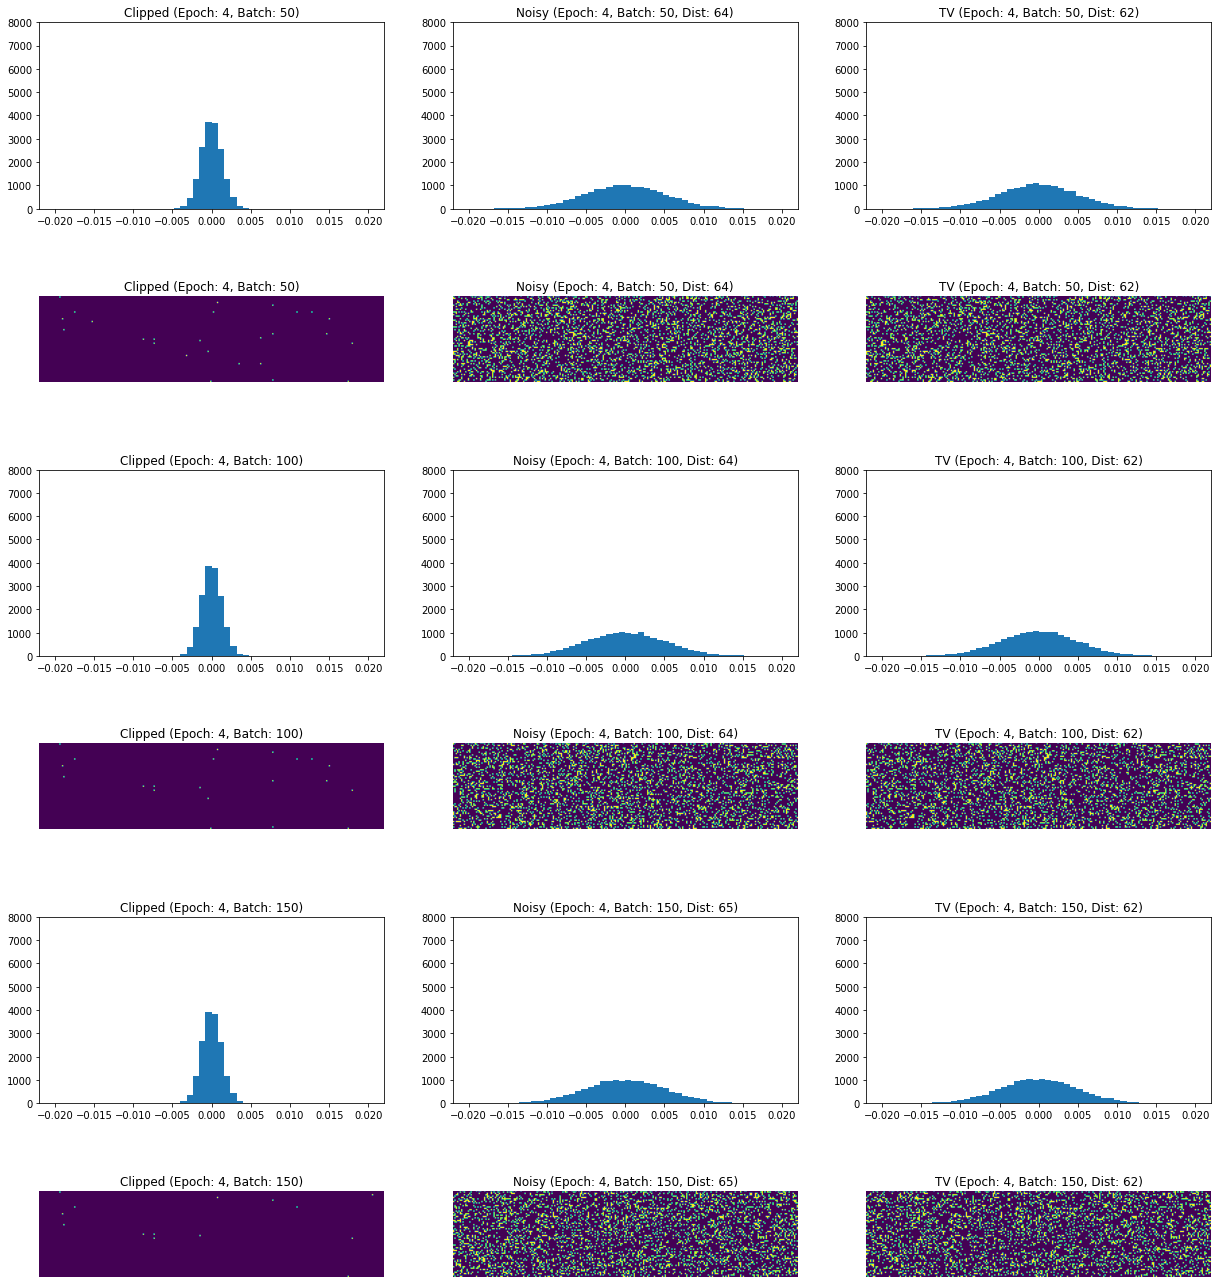

In [9]:
watchdog = PrivacyWatchdog(
    train_loader,
    target_epsilon=1.0,
    abort=False,
    target_delta=1e-5,
    fallback_to_rdp=False,
)
model = PrivacyWrapper(SimpleNet(), args.batch_size, 1.0, 1.0, watchdog=watchdog).to(
    args.device
)
optimizer = torch.optim.SGD(model.wrapped_model.parameters(), lr=0.1)

surgeon = ModelSurgeon(SurgicalProcedures.BN_to_GN)
model = surgeon.operate(model)

weight = 0.0001
noisy_dists = np.array([])
gauss_dists = np.array([])
plot_layer = 2
y_lim = 8000
rows = 6
columns = 3
i = 1
fig = plt.figure(figsize=(columns*7, rows*4))

# Train
for epoch in range(args.num_epochs):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = torch.nn.CrossEntropyLoss()(output, target)
        loss.backward()
        
        if epoch == 4 and (batch_idx == 50 or batch_idx == 100 or batch_idx == 150):
            model.clip_and_accumulate()
            
            clipped_grad = torch.flatten(model.wrapped_model.fc2.weight.grad).detach().clone()
            
            title = "Clipped (Epoch: " + str(epoch) + ", Batch: " + str(batch_idx) + ")"
            plot_grad_hist(model.wrapped_model, plot_layer, rows, columns, i, title, y_lim)
            plot_grad_image(model.wrapped_model, plot_layer, rows, columns, i+3, title)

            model.noise_gradient()

            noisy_dist = sum(abs(clipped_grad - torch.flatten(model.wrapped_model.fc2.weight.grad)))
            noisy_dists = np.append(noisy_dists, noisy_dist)
            title = "Noisy (Epoch: " + str(epoch) + ", Batch: " + str(batch_idx) + ", Dist: " + str(int(noisy_dist)) + ")"
            plot_grad_hist(model.wrapped_model, plot_layer, rows, columns, i+1, title, y_lim)
            plot_grad_image(model.wrapped_model, plot_layer, rows, columns, i+4, title)
            
            tv_denoiser(model, weight)
            
            gauss_dist = sum(abs(clipped_grad - torch.flatten(model.wrapped_model.fc2.weight.grad)))
            gauss_dists = np.append(gauss_dists, gauss_dist)
            title="TV (Epoch: " + str(epoch) + ", Batch: " + str(batch_idx) + ", Dist: " + str(int(gauss_dist)) + ")"
            plot_grad_hist(model.wrapped_model, plot_layer, rows, columns, i+2, title, y_lim)
            plot_grad_image(model.wrapped_model, plot_layer, rows, columns, i+5, title)
            
            i = i+6
        else:
            model.clip_and_accumulate()
            model.noise_gradient()
            tv_denoiser(model, weight)

        optimizer.step()
        model.prepare_next_batch()
        if batch_idx % args.log_interval == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    len(train_loader.dataset),
                    100.0 * batch_idx / len(train_loader),
                    loss.item(),
                )
            )

    # Test
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += torch.nn.CrossEntropyLoss(reduction="sum")(
                output, target
            ).item()  # sum up batch loss
            pred = output.argmax(
                dim=1, keepdim=True
            )  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print(
        "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)".format(
            test_loss,
            correct,
            len(test_loader.dataset),
            100.0 * correct / len(test_loader.dataset),
        )
    )

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.344959


INFO:root:Privacy spent at 100 steps: 0.18
INFO:root:Privacy spent at 200 steps: 0.27
INFO:root:Privacy spent at 300 steps: 0.34



Test set: Average loss: 0.6346, Accuracy: 8349/10000 (83%)
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.690975


INFO:root:Privacy spent at 400 steps: 0.39
INFO:root:Privacy spent at 500 steps: 0.44
INFO:root:Privacy spent at 600 steps: 0.49



Test set: Average loss: 0.4115, Accuracy: 8951/10000 (90%)
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.309386


INFO:root:Privacy spent at 700 steps: 0.53
INFO:root:Privacy spent at 800 steps: 0.57
INFO:root:Privacy spent at 900 steps: 0.61



Test set: Average loss: 0.3847, Accuracy: 9074/10000 (91%)
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.515105


INFO:root:Privacy spent at 1000 steps: 0.65
INFO:root:Privacy spent at 1100 steps: 0.68
INFO:root:Privacy spent at 1200 steps: 0.72



Test set: Average loss: 0.3224, Accuracy: 9159/10000 (92%)
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.391955


INFO:root:Privacy spent at 1300 steps: 0.75
INFO:root:Privacy spent at 1400 steps: 0.78
INFO:root:Privacy spent at 1500 steps: 0.81



Test set: Average loss: 0.2925, Accuracy: 9266/10000 (93%)


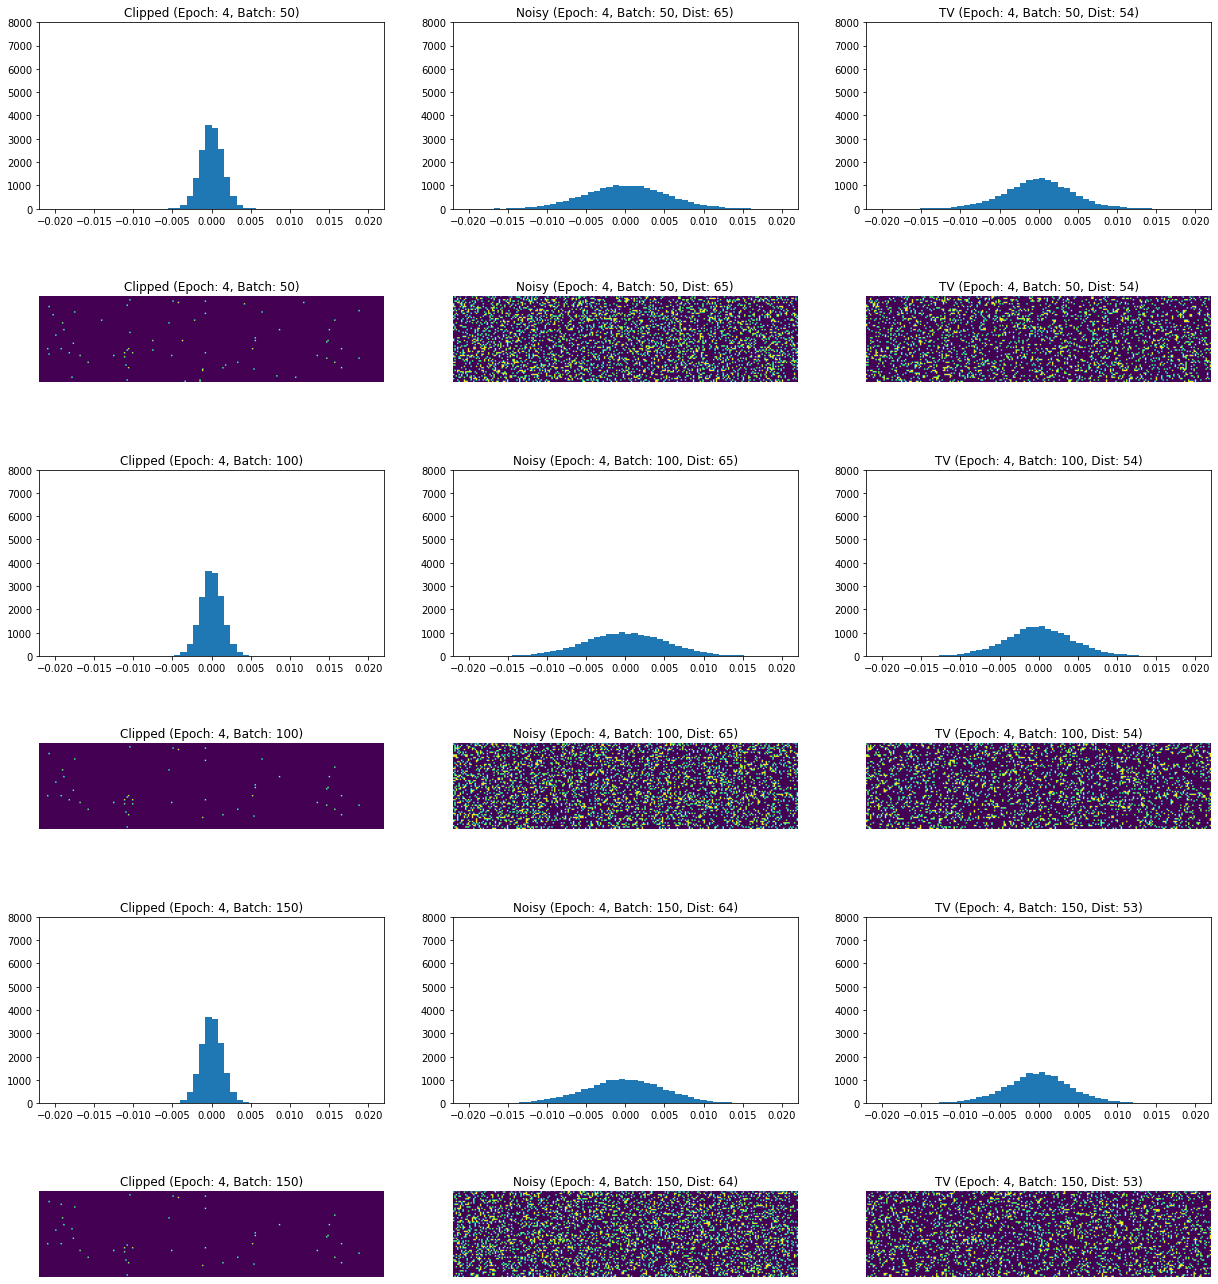

In [10]:
watchdog = PrivacyWatchdog(
    train_loader,
    target_epsilon=1.0,
    abort=False,
    target_delta=1e-5,
    fallback_to_rdp=False,
)
model = PrivacyWrapper(SimpleNet(), args.batch_size, 1.0, 1.0, watchdog=watchdog).to(
    args.device
)
optimizer = torch.optim.SGD(model.wrapped_model.parameters(), lr=0.1)

surgeon = ModelSurgeon(SurgicalProcedures.BN_to_GN)
model = surgeon.operate(model)

weight = 0.0005
noisy_dists = np.array([])
gauss_dists = np.array([])
plot_layer = 2
y_lim = 8000
rows = 6
columns = 3
i = 1
fig = plt.figure(figsize=(columns*7, rows*4))

# Train
for epoch in range(args.num_epochs):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = torch.nn.CrossEntropyLoss()(output, target)
        loss.backward()
        
        if epoch == 4 and (batch_idx == 50 or batch_idx == 100 or batch_idx == 150):
            model.clip_and_accumulate()
            
            clipped_grad = torch.flatten(model.wrapped_model.fc2.weight.grad).detach().clone()
            
            title = "Clipped (Epoch: " + str(epoch) + ", Batch: " + str(batch_idx) + ")"
            plot_grad_hist(model.wrapped_model, plot_layer, rows, columns, i, title, y_lim)
            plot_grad_image(model.wrapped_model, plot_layer, rows, columns, i+3, title)

            model.noise_gradient()

            noisy_dist = sum(abs(clipped_grad - torch.flatten(model.wrapped_model.fc2.weight.grad)))
            noisy_dists = np.append(noisy_dists, noisy_dist)
            title = "Noisy (Epoch: " + str(epoch) + ", Batch: " + str(batch_idx) + ", Dist: " + str(int(noisy_dist)) + ")"
            plot_grad_hist(model.wrapped_model, plot_layer, rows, columns, i+1, title, y_lim)
            plot_grad_image(model.wrapped_model, plot_layer, rows, columns, i+4, title)
            
            tv_denoiser(model, weight)
            
            gauss_dist = sum(abs(clipped_grad - torch.flatten(model.wrapped_model.fc2.weight.grad)))
            gauss_dists = np.append(gauss_dists, gauss_dist)
            title="TV (Epoch: " + str(epoch) + ", Batch: " + str(batch_idx) + ", Dist: " + str(int(gauss_dist)) + ")"
            plot_grad_hist(model.wrapped_model, plot_layer, rows, columns, i+2, title, y_lim)
            plot_grad_image(model.wrapped_model, plot_layer, rows, columns, i+5, title)
            
            i = i+6
        else:
            model.clip_and_accumulate()
            model.noise_gradient()
            tv_denoiser(model, weight)

        optimizer.step()
        model.prepare_next_batch()
        if batch_idx % args.log_interval == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    len(train_loader.dataset),
                    100.0 * batch_idx / len(train_loader),
                    loss.item(),
                )
            )

    # Test
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += torch.nn.CrossEntropyLoss(reduction="sum")(
                output, target
            ).item()  # sum up batch loss
            pred = output.argmax(
                dim=1, keepdim=True
            )  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print(
        "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)".format(
            test_loss,
            correct,
            len(test_loader.dataset),
            100.0 * correct / len(test_loader.dataset),
        )
    )